# Milvus로 이미지 검색하기
- 데이터 세트 준비
- wget https://github.com/milvus-io/pymilvus-assets/releases/download/imagedata/reverse_image_search.zip
- unzip -q -o reverse_image_search.zip


In [9]:
import torch
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [17]:
class FeatureExtractor:
    def __init__(self, model_name):
        # 사전 학습 모델 부르기
        self.model = timm.create_model(
            model_name, pretrained=True, num_classes=0, global_pool="avg"
        )
        self.model.eval()

        # model input 사이즈 확인
        self.input_size = self.model.default_cfg["input_size"]

        config = resolve_data_config({}, model=model_name)

        # Torch transforms 적용
        self.preprocess = create_transform(**config)

    def __call__(self, image_path):
        # Preprocess the input image
        input_image = Image.open(image_path).convert("RGB") # Convert to RGB if needed
        input_image = self.preprocess(input_image)

        # 배치 dimenssion 추가
        input_tensor = input_image.unsqueeze(0)

        # Perfrom inference
        with torch.no_grad():
            output = self.model(input_tensor)

        # 피처 추출기
        feature_vector = output.squeeze().numpy()

        return normalize(feature_vector.reshape(1, -1), norm="l2").flatten()

# Milvus 컬렉션 만들기

In [18]:
from pymilvus import MilvusClient

client = MilvusClient(uri="example.db")

if client.has_collection(collection_name="image_embeddings"):
    client.drop_collection(collection_name="image_embeddings")
client.create_collection(
    collection_name="image_embeddings",
    vector_field_name="vector",
    dimension=512,
    auto_id=True,
    enable_dynamic_field=True,
    metric_type="COSINE",
)

In [19]:
client.describe_collection(collection_name="image_embeddings")

{'collection_name': 'image_embeddings',
 'auto_id': True,
 'num_shards': 0,
 'description': '',
 'fields': [{'field_id': 100,
   'name': 'id',
   'description': '',
   'type': <DataType.INT64: 5>,
   'params': {},
   'auto_id': True,
   'is_primary': True},
  {'field_id': 101,
   'name': 'vector',
   'description': '',
   'type': <DataType.FLOAT_VECTOR: 101>,
   'params': {'dim': 512}}],
 'functions': [],
 'aliases': [],
 'collection_id': 0,
 'consistency_level': 0,
 'properties': {},
 'num_partitions': 0,
 'enable_dynamic_field': True}

# 밀버스에 임베딩 삽입하기

In [22]:
import os

extractor = FeatureExtractor("resnet34")

root = "./train"
insert = True
if insert is True:
    for dir_path, folder_name, filenames in os.walk(root):
        for filename in filenames:
            if filename.endswith(".JPEG"):
                file_path = os.path.join(dir_path, filename)
                image_embedding = extractor(file_path)
                client.insert(
                    "image_embeddings",
                    {
                        "vector": image_embedding,
                        "filename": file_path
                    },
                )

'query'

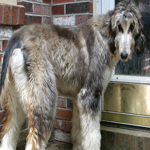

'results'

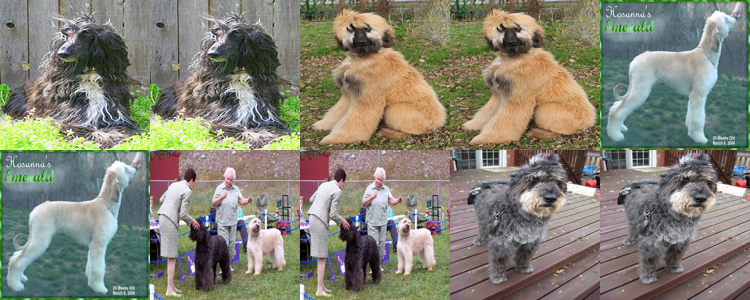

In [26]:
from IPython.display import display

query_image = "./test/Afghan_hound/n02088094_4261.JPEG"

results = client.search(
    "image_embeddings",
    data=[extractor(query_image)],
    output_fields=["filename"],
    search_params={"metric_type": "COSINE"},
)
images = []
for result in results:
    for hit in result[:10]:
        filename = hit["entity"]["filename"]
        img = Image.open(filename)
        img = img.resize((150, 150))
        images.append(img)

width = 150 * 5
height = 150 * 2
concatenated_image = Image.new("RGB", (width, height))

for idx, img in enumerate(images):
    x = idx % 5
    y = idx // 5
    concatenated_image.paste(img, (x * 150, y * 150))
display("query")
display(Image.open(query_image).resize((150, 150)))
display("results")
display(concatenated_image)


# 컬렉션 스키마 확인

In [27]:
schema = client.describe_collection(collection_name="image_embeddings")

In [28]:
schema

{'collection_name': 'image_embeddings',
 'auto_id': True,
 'num_shards': 0,
 'description': '',
 'fields': [{'field_id': 100,
   'name': 'id',
   'description': '',
   'type': <DataType.INT64: 5>,
   'params': {},
   'auto_id': True,
   'is_primary': True},
  {'field_id': 101,
   'name': 'vector',
   'description': '',
   'type': <DataType.FLOAT_VECTOR: 101>,
   'params': {'dim': 512}}],
 'functions': [],
 'aliases': [],
 'collection_id': 0,
 'consistency_level': 0,
 'properties': {},
 'num_partitions': 0,
 'enable_dynamic_field': True}

# T-SNE 시각화

In [49]:
from pymilvus import MilvusClient
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [50]:
limit = 10000

# 벡터는 "vector"라는 필드명
res = client.query(
    collection_name="image_embeddings",
    filter="",  # 필터 조건 없으면 전체
    output_fields=["vector"],
    limit=limit
)

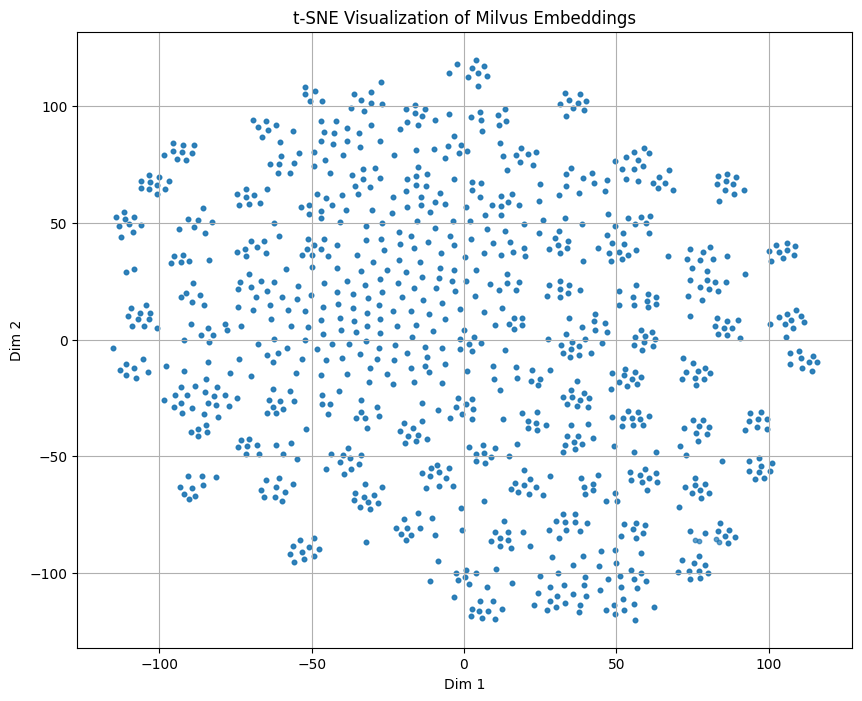

In [51]:
# 벡터만 추출
vectors = np.array([r["vector"] for r in res])

# t-SNE로 2차원 축소
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# 시각화
plt.figure(figsize=(10, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=10, alpha=0.7)
plt.title("t-SNE Visualization of Milvus Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()